In [1]:
!pip install keras

In [2]:
!pip install more_itertools

In [3]:
!pip install gym

In [4]:
!pip install yfinance

     |████████████████████████████████| 5.5MB 10.0MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22616 sha256=76761410930898d2243c51b7bc9c27fa9bd056a1624741e83c54ce358ae3a94c
  Stored in directory: /root/.cache/pip/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [5]:
!pip install QuantStats

  Created wheel for QuantStats: filename=QuantStats-0.0.26-py2.py3-none-any.whl size=36979 sha256=5787ca0f47fe3df2b148f70343e9e98ae7d2a0ee1c42e58718857312ad969339
  Stored in directory: /root/.cache/pip/wheels/e2/29/82/c3cdde9eb76e7ed91e6aff057e4a53f52a7226c0eb09df90e0
Successfully built QuantStats


In [6]:
url = 'https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files'
!wget $url/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
!wget $url/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib

Selecting previously unselected package libta-lib0.
(Reading database ... 160980 files and directories currently installed.)
Preparing to unpack libta.deb ...
Unpacking libta-lib0 (0.4.0-oneiric1) ...
Selecting previously unselected package ta-lib0-dev.
Preparing to unpack ta.deb ...
Unpacking ta-lib0-dev (0.4.0-oneiric1) ...
Setting up libta-lib0 (0.4.0-oneiric1) ...
Setting up ta-lib0-dev (0.4.0-oneiric1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.2) ...
/sbin/ldconfig.real: /usr/local/lib/python3.7/dist-packages/ideep4py/lib/libmkldnn.so.0 is not a symbolic link

     |████████████████████████████████| 276kB 8.4MB/s 
  Created wheel for ta-lib: filename=TA_Lib-0.4.19-cp37-cp37m-linux_x86_64.whl size=1438007 sha256=a90e7791d429e8683e5b799c215a9519da724fccbc97d07567fafd83497029de
  Stored in directory: /root/.cache/pip/wheels/a3/f6/12/3d1ccd06caadd8fa47e016991dd0d27f1163bb260f1854e2ff
Successfully built ta-lib


In [36]:
import yfinance as yf
import quantstats
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from pandas.tseries.offsets import BDay
import talib


PERIOD_DEFAULT = '1d'
START_DEFAULT, END_DEFAULT  = '2012-1-26', '2018-1-25'
BACKTEST_START_DEFAULT, BACKTEST_END_DEFAULT  = '2018-1-26', '2018-12-26'
COLUMNS = ["Open",	"High"	, "Low",	"Close",	"Volume"]


def pull_intraday_time_series(ticker_symbol, period=PERIOD_DEFAULT, start=START_DEFAULT, end=END_DEFAULT, columns=COLUMNS):
    """Pull intraday time series data by stock ticker name.

    Args:
        ticker_symbol (Str): Ticker name that we want to pull.
        period (str, optional): frequency of data. Defaults to PERIOD_DEFAULT.
        start (str, optional): data of start. Defaults to START_DEFAULT.
        end (str, optional): date of end. Defaults to END_DEFAULT.
        columns ([str],optional): names of columns used as observations used in RL training
    """

    # get data on this ticker
    tickerData = yf.Ticker(ticker_symbol)

    # get the historical prices for this ticker
    tickerDf = tickerData.history(period=period, start=start, end=end)

    return tickerDf[columns].reset_index()

In [ ]:
"""
Remark: We have used the gym enviromnment implemented by the authors in their repo
with some modifications to fit our paradigm of implementation
link to repo : https://github.com/ThibautTheate/An-Application-of-Deep-Reinforcement-Learning-to-Algorithmic-Trading
"""

###############################################################################
################################### Imports ###################################
###############################################################################

from more_itertools import collapse
from matplotlib import pyplot as plt
import os
import gym
import math
import numpy as np

import pandas as pd
pd.options.mode.chained_assignment = None


###############################################################################
################################ Global variables #############################
###############################################################################

# Boolean handling the saving of the stock market data downloaded
saving = True

Actions = [0, 1]


###############################################################################
############################## Class TradingEnv ###############################
###############################################################################

class TradingEnv(gym.Env):
    """
    GOAL: Implement a custom trading environment compatible with OpenAI Gym.

    VARIABLES:  - data: Dataframe monitoring the trading activity.
                - state: RL state to be returned to the RL agent.
                - reward: RL reward to be returned to the RL agent.
                - done: RL episode termination signal.
                - t: Current trading time step.
                - marketSymbol: Stock market symbol.
                - startingDate: Beginning of the trading horizon.
                - endingDate: Ending of the trading horizon.
                - stateLength: Number of trading time steps included in the state.
                - numberOfShares: Number of shares currently owned by the agent.
                - transactionCosts: Transaction costs associated with the trading
                                    activity (e.g. 0.01 is 1% of loss).

    METHODS:    - __init__: Object constructor initializing the trading environment.
                - reset: Perform a soft reset of the trading environment.
                - step: Transition to the next trading time step.
                - render: Illustrate graphically the trading environment.
    """

    def __init__(self, marketSymbol, period, startingDate, endingDate, columns, money, stateLength=30,
                 transactionCosts=0, startingPoint=0):
        """
        GOAL: Object constructor initializing the trading environment by setting up
              the trading activity dataframe as well as other important variables.

        INPUTS: - marketSymbol: Stock market symbol.
                - startingDate: Beginning of the trading horizon.
                - endingDate: Ending of the trading horizon.
                - money: Initial amount of money at the disposal of the agent.
                - stateLength: Number of trading time steps included in the RL state.
                - transactionCosts: Transaction costs associated with the trading
                                    activity (e.g. 0.01 is 1% of loss).
                - startingPoint: Optional starting point (iteration) of the trading activity.

        OUTPUTS: /
        """

        # np.random.seed(200)

        self.data = pull_intraday_time_series(
            marketSymbol, period, startingDate, endingDate, columns)

        # Set the trading activity dataframe
        self.data['Position'] = 0
        self.data['Action'] = 0
        self.data['Holdings'] = 0.
        self.data['Cash'] = float(money)
        self.data['Money'] = self.data['Holdings'] + self.data['Cash']
        self.data['Returns'] = 0.

        # Set the RL variables common to every OpenAI gym environments
        self.state = np.array(list(collapse([self.data['Close'][0:stateLength].tolist(),
                                             self.data['Low'][0:stateLength].tolist(
        ),
            self.data['High'][0:stateLength].tolist(
        ),
            self.data['Volume'][0:stateLength].tolist(),
            [0]])))
        self.reward = 0.
        self.done = 0

        # Set additional variables related to the trading activity
        self.marketSymbol = marketSymbol
        self.startingDate = startingDate
        self.endingDate = endingDate
        self.stateLength = stateLength
        self.t = stateLength
        self.numberOfShares = 0
        self.transactionCosts = transactionCosts
        self.epsilon = 0.1

        # spaces
        self.action_space = gym.spaces.Discrete(len(Actions))
        self.observation_space = gym.spaces.Box(
            low=-np.inf, high=np.inf, shape=(len(self.state),), dtype=np.float32)

        # If required, set a custom starting point for the trading activity
        if startingPoint:
            self.setStartingPoint(startingPoint)

    def reset(self):
        """
        GOAL: Perform a soft reset of the trading environment. 

        INPUTS: /    

        OUTPUTS: - state: RL state returned to the trading strategy.
        """

        # Reset the trading activity dataframe
        self.data['Position'] = 0
        self.data['Action'] = 0
        self.data['Holdings'] = 0.
        self.data['Cash'] = self.data['Cash'][0]
        self.data['Money'] = self.data['Holdings'] + self.data['Cash']
        self.data['Returns'] = 0.

        # Reset the RL variables common to every OpenAI gym environments
        self.state = np.array(list(collapse([self.data['Close'][0:self.stateLength].tolist(),
                                             self.data['Low'][0:self.stateLength].tolist(
        ),
            self.data['High'][0:self.stateLength].tolist(
        ),
            self.data['Volume'][0:self.stateLength].tolist(),
            [0]])))
        self.reward = 0.
        self.done = 0

        # Reset additional variables related to the trading activity
        self.t = self.stateLength
        self.numberOfShares = 0

        return self.state

    def computeLowerBound(self, cash, numberOfShares, price):
        """
        GOAL: Compute the lower bound of the complete RL action space, 
              i.e. the minimum number of share to trade.

        INPUTS: - cash: Value of the cash owned by the agent.
                - numberOfShares: Number of shares owned by the agent.
                - price: Last price observed.

        OUTPUTS: - lowerBound: Lower bound of the RL action space.
        """

        # Computation of the RL action lower bound
        deltaValues = - cash - numberOfShares * price * \
            (1 + self.epsilon) * (1 + self.transactionCosts)
        if deltaValues < 0:
            lowerBound = deltaValues / \
                (price * (2 * self.transactionCosts +
                          (self.epsilon * (1 + self.transactionCosts))))
        else:
            lowerBound = deltaValues / \
                (price * self.epsilon * (1 + self.transactionCosts))
        return lowerBound

    def step(self, action):
        """
        GOAL: Transition to the next trading time step based on the
              trading position decision made (either long or short).

        INPUTS: - action: Trading decision (1 = long, 0 = short).    

        OUTPUTS: - state: RL state to be returned to the RL agent.
                 - reward: RL reward to be returned to the RL agent.
                 - done: RL episode termination signal (boolean).
                 - info: Additional information returned to the RL agent.
        """

        # Stting of some local variables
        t = self.t
        numberOfShares = self.numberOfShares
        customReward = False

        # CASE 1: LONG POSITION
        if(action == 1):
            self.data['Position'][t] = 1
            # Case a: Long -> Long
            if(self.data['Position'][t - 1] == 1):
                self.data['Cash'][t] = self.data['Cash'][t - 1]
                self.data['Holdings'][t] = self.numberOfShares * \
                    self.data['Close'][t]
            # Case b: No position -> Long
            elif(self.data['Position'][t - 1] == 0):
                self.numberOfShares = math.floor(
                    self.data['Cash'][t - 1]/(self.data['Close'][t] * (1 + self.transactionCosts)))
                self.data['Cash'][t] = self.data['Cash'][t - 1] - self.numberOfShares * \
                    self.data['Close'][t] * (1 + self.transactionCosts)
                self.data['Holdings'][t] = self.numberOfShares * \
                    self.data['Close'][t]
                self.data['Action'][t] = 1
            # Case c: Short -> Long
            else:
                self.data['Cash'][t] = self.data['Cash'][t - 1] - self.numberOfShares * \
                    self.data['Close'][t] * (1 + self.transactionCosts)
                self.numberOfShares = math.floor(
                    self.data['Cash'][t]/(self.data['Close'][t] * (1 + self.transactionCosts)))
                self.data['Cash'][t] = self.data['Cash'][t] - self.numberOfShares * \
                    self.data['Close'][t] * (1 + self.transactionCosts)
                self.data['Holdings'][t] = self.numberOfShares * \
                    self.data['Close'][t]
                self.data['Action'][t] = 1

        # CASE 2: SHORT POSITION
        elif(action == 0):
            self.data['Position'][t] = -1
            # Case a: Short -> Short
            if(self.data['Position'][t - 1] == -1):
                lowerBound = self.computeLowerBound(
                    self.data['Cash'][t - 1], -numberOfShares, self.data['Close'][t-1])
                if lowerBound <= 0:
                    self.data['Cash'][t] = self.data['Cash'][t - 1]
                    self.data['Holdings'][t] = - \
                        self.numberOfShares * self.data['Close'][t]
                else:
                    numberOfSharesToBuy = min(math.floor(
                        lowerBound), self.numberOfShares)
                    self.numberOfShares -= numberOfSharesToBuy
                    self.data['Cash'][t] = self.data['Cash'][t - 1] - numberOfSharesToBuy * \
                        self.data['Close'][t] * (1 + self.transactionCosts)
                    self.data['Holdings'][t] = - \
                        self.numberOfShares * self.data['Close'][t]
                    customReward = True
            # Case b: No position -> Short
            elif(self.data['Position'][t - 1] == 0):
                self.numberOfShares = math.floor(
                    self.data['Cash'][t - 1]/(self.data['Close'][t] * (1 + self.transactionCosts)))
                self.data['Cash'][t] = self.data['Cash'][t - 1] + self.numberOfShares * \
                    self.data['Close'][t] * (1 - self.transactionCosts)
                self.data['Holdings'][t] = - \
                    self.numberOfShares * self.data['Close'][t]
                self.data['Action'][t] = -1
            # Case c: Long -> Short
            else:
                self.data['Cash'][t] = self.data['Cash'][t - 1] + self.numberOfShares * \
                    self.data['Close'][t] * (1 - self.transactionCosts)
                self.numberOfShares = math.floor(
                    self.data['Cash'][t]/(self.data['Close'][t] * (1 + self.transactionCosts)))
                self.data['Cash'][t] = self.data['Cash'][t] + self.numberOfShares * \
                    self.data['Close'][t] * (1 - self.transactionCosts)
                self.data['Holdings'][t] = - \
                    self.numberOfShares * self.data['Close'][t]
                self.data['Action'][t] = -1

        # CASE 3: PROHIBITED ACTION
        else:
            raise SystemExit(
                "Prohibited action! Action should be either 1 (long) or 0 (short).")

        # Update the total amount of money owned by the agent, as well as the return generated
        self.data['Money'][t] = self.data['Holdings'][t] + self.data['Cash'][t]
        self.data['Returns'][t] = (
            self.data['Money'][t] - self.data['Money'][t-1])/self.data['Money'][t-1]

        # Set the RL reward returned to the trading agent
        if not customReward:
            self.reward = self.data['Returns'][t]
        else:
            self.reward = (self.data['Close'][t-1] -
                           self.data['Close'][t])/self.data['Close'][t-1]

        # Transition to the next trading time step
        self.t = self.t + 1
        self.state = np.array(list(collapse([self.data['Close'][self.t - self.stateLength: self.t].tolist(),
                                             self.data['Low'][self.t -
                                                              self.stateLength: self.t].tolist(),
                                             self.data['High'][self.t -
                                                               self.stateLength: self.t].tolist(),
                                             self.data['Volume'][self.t -
                                                                 self.stateLength: self.t].tolist(),
                                             [self.data['Position'][self.t - 1]]])))
        if(self.t == self.data.shape[0]):
            self.done = 1

        # Same reasoning with the other action (exploration trick)
        otherAction = int(not bool(action))
        customReward = False
        if(otherAction == 1):
            otherPosition = 1
            if(self.data['Position'][t - 1] == 1):
                otherCash = self.data['Cash'][t - 1]
                otherHoldings = numberOfShares * self.data['Close'][t]
            elif(self.data['Position'][t - 1] == 0):
                numberOfShares = math.floor(
                    self.data['Cash'][t - 1]/(self.data['Close'][t] * (1 + self.transactionCosts)))
                otherCash = self.data['Cash'][t - 1] - numberOfShares * \
                    self.data['Close'][t] * (1 + self.transactionCosts)
                otherHoldings = numberOfShares * self.data['Close'][t]
            else:
                otherCash = self.data['Cash'][t - 1] - numberOfShares * \
                    self.data['Close'][t] * (1 + self.transactionCosts)
                numberOfShares = math.floor(
                    otherCash/(self.data['Close'][t] * (1 + self.transactionCosts)))
                otherCash = otherCash - numberOfShares * \
                    self.data['Close'][t] * (1 + self.transactionCosts)
                otherHoldings = numberOfShares * self.data['Close'][t]
        else:
            otherPosition = -1
            if(self.data['Position'][t - 1] == -1):
                lowerBound = self.computeLowerBound(
                    self.data['Cash'][t - 1], -numberOfShares, self.data['Close'][t-1])
                if lowerBound <= 0:
                    otherCash = self.data['Cash'][t - 1]
                    otherHoldings = - numberOfShares * self.data['Close'][t]
                else:
                    numberOfSharesToBuy = min(
                        math.floor(lowerBound), numberOfShares)
                    numberOfShares -= numberOfSharesToBuy
                    otherCash = self.data['Cash'][t - 1] - numberOfSharesToBuy * \
                        self.data['Close'][t] * (1 + self.transactionCosts)
                    otherHoldings = - numberOfShares * self.data['Close'][t]
                    customReward = True
            elif(self.data['Position'][t - 1] == 0):
                numberOfShares = math.floor(
                    self.data['Cash'][t - 1]/(self.data['Close'][t] * (1 + self.transactionCosts)))
                otherCash = self.data['Cash'][t - 1] + numberOfShares * \
                    self.data['Close'][t] * (1 - self.transactionCosts)
                otherHoldings = - numberOfShares * self.data['Close'][t]
            else:
                otherCash = self.data['Cash'][t - 1] + numberOfShares * \
                    self.data['Close'][t] * (1 - self.transactionCosts)
                numberOfShares = math.floor(
                    otherCash/(self.data['Close'][t] * (1 + self.transactionCosts)))
                otherCash = otherCash + numberOfShares * \
                    self.data['Close'][t] * (1 - self.transactionCosts)
                otherHoldings = - self.numberOfShares * self.data['Close'][t]
        otherMoney = otherHoldings + otherCash
        if not customReward:
            otherReward = (
                otherMoney - self.data['Money'][t-1])/self.data['Money'][t-1]
        else:
            otherReward = (self.data['Close'][t-1] -
                           self.data['Close'][t])/self.data['Close'][t-1]
        otherState = np.array(list(collapse([self.data['Close'][self.t - self.stateLength: self.t].tolist(),
                                             self.data['Low'][self.t -
                                                              self.stateLength: self.t].tolist(),
                                             self.data['High'][self.t -
                                                               self.stateLength: self.t].tolist(),
                                             self.data['Volume'][self.t -
                                                                 self.stateLength: self.t].tolist(),
                                             [otherPosition]])))
        self.info = {'State': otherState,
                     'Reward': otherReward, 'Done': self.done}

        # Return the trading environment feedback to the RL trading agent
        return self.state, self.reward, self.done, self.info

    def render(self):
        """
        GOAL: Illustrate graphically the trading activity, by plotting
              both the evolution of the stock market price and the 
              evolution of the trading capital. All the trading decisions
              (long and short positions) are displayed as well.

        INPUTS: /   

        OUTPUTS: /
        """

        # Set the Matplotlib figure and subplots
        fig = plt.figure(figsize=(10, 8))
        ax1 = fig.add_subplot(211, ylabel='Price', xlabel='Time')
        ax2 = fig.add_subplot(212, ylabel='Capital', xlabel='Time', sharex=ax1)

        # Plot the first graph -> Evolution of the stock market price
        self.data['Close'].plot(ax=ax1, color='blue', lw=2)
        ax1.plot(self.data.loc[self.data['Action'] == 1.0].index,
                 self.data['Close'][self.data['Action'] == 1.0],
                 '^', markersize=5, color='green')
        ax1.plot(self.data.loc[self.data['Action'] == -1.0].index,
                 self.data['Close'][self.data['Action'] == -1.0],
                 'v', markersize=5, color='red')

        # Plot the second graph -> Evolution of the trading capital
        self.data['Money'].plot(ax=ax2, color='blue', lw=2)
        ax2.plot(self.data.loc[self.data['Action'] == 1.0].index,
                 self.data['Money'][self.data['Action'] == 1.0],
                 '^', markersize=5, color='green')
        ax2.plot(self.data.loc[self.data['Action'] == -1.0].index,
                 self.data['Money'][self.data['Action'] == -1.0],
                 'v', markersize=5, color='red')

        # Generation of the two legends and plotting
        ax1.legend(["Price", "Long",  "Short"])
        ax2.legend(["Capital", "Long", "Short"])
        plt.show()

    def setStartingPoint(self, startingPoint):
        """
        GOAL: Setting an arbitrary starting point regarding the trading activity.
              This technique is used for better generalization of the RL agent.

        INPUTS: - startingPoint: Optional starting point (iteration) of the trading activity.

        OUTPUTS: /
        """

        # Setting a custom starting point
        self.t = np.clip(startingPoint, self.stateLength, len(self.data.index))

        # Set the RL variables common to every OpenAI gym environments
        self.state = np.array(list(collapse([self.data['Close'][self.t - self.stateLength: self.t].tolist(),
                                             self.data['Low'][self.t -
                                                              self.stateLength: self.t].tolist(),
                                             self.data['High'][self.t -
                                                               self.stateLength: self.t].tolist(),
                                             self.data['Volume'][self.t -
                                                                 self.stateLength: self.t].tolist(),
                                             [self.data['Position'][self.t - 1]]])))
        if(self.t == self.data.shape[0]):
            self.done = 1

In [16]:
from keras.layers import Dense, Activation, BatchNormalization
from keras.models import Sequential, load_model
from keras.optimizers import Adam
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.random import set_seed
import quantstats as qs


#########################
######### Utils #########
#########################

def performance_metrics(ts):
    """
      Computes sharpe ratio, sortino ratio, annualized volatility, profit ratio given a capital time serie

      Args:
          ts (pd.Series or np.array): Capital time series (holdings+cash)

    """

    returns = ts.pct_change()
    metric_names = {'sharpe': 'Sharpe Ratio', 'sortino': 'Sortino Ratio',
                    'volatility': 'Annualized Volatility', 'profit_ratio': 'Profit Ratio'}
    dict_metrics = {}

    if returns.std() != 0:
        for key, value in metric_names.items():
            metric_to_call = getattr(quantstats.stats, key)
            metric_value = metric_to_call(returns)
            dict_metrics[value] = round(metric_value, 2)

        dict_metrics['Max Drawdown'] = round(qs.stats.max_drawdown(ts), 2)
        dict_metrics['Annualized Retruns'] = round(returns.mean()*252, 2)
    else:
        for key, value in metric_names.items():
            dict_metrics[value] = 0
            dict_metrics['Max Drawdown'] = round(qs.stats.max_drawdown(ts), 2)
            dict_metrics['Annualized Retruns'] = round(returns.mean()*252, 2)

    return(dict_metrics)



def plotLearning(x, scores, epsilons, lines=None):
    """Plots evolution of epsilon and reward in the training process

    Args:
        x (array): episodes list
        scores (array): reward evolution array
        epsilons (array): epsilon evolution array
        lines (array, optional): feature for adding vertical line across the axes.. Defaults to None.
    """

    fig = plt.figure()
    ax = fig.add_subplot(111, label="1")
    ax2 = fig.add_subplot(111, label="2", frame_on=False)

    ax.plot(x, epsilons, color="C0")
    ax.set_xlabel("Episode", color="C0")
    ax.set_ylabel("Epsilon", color="C0")
    ax.tick_params(axis='x', colors="C0")
    ax.tick_params(axis='y', colors="C0")

    N = len(scores)
    running_avg = np.empty(N)
    for t in range(N):
        running_avg[t] = np.mean(scores[max(0, t-20):(t+1)])

    ax2.scatter(x, running_avg, color="C1")
    # ax2.xaxis.tick_top()
    ax2.axes.get_xaxis().set_visible(False)
    ax2.yaxis.tick_right()
    #ax2.set_xlabel('x label 2', color="C1")
    ax2.set_ylabel('Score', color="C1")
    # ax2.xaxis.set_label_position('top')
    ax2.yaxis.set_label_position('right')
    #ax2.tick_params(axis='x', colors="C1")
    ax2.tick_params(axis='y', colors="C1")

    if lines is not None:
        for line in lines:
            plt.axvline(x=line)

    plt.show()


#################################
######### Replay buffer #########
#################################

class ReplayBuffer(object):
    """Replay buffer for Deep Reinforcement Learning Agent

    """

    def __init__(self, max_size, input_shape, n_actions, discrete=False):
        """Constructor of replay buffer

        Args:
            max_size (int): maximum size of the memory
            input_shape (int): input shape of the environment
            n_actions ([int]): number of possible actions
            discrete (bool, optional): check if actions are integer. Defaults to False.
        """
        self.mem_size = max_size
        self.mem_cntr = 0
        self.discrete = discrete
        self.state_memory = np.zeros((self.mem_size, input_shape))
        self.new_state_memory = np.zeros((self.mem_size, input_shape))
        dtype = np.int8 if self.discrete else np.float32
        self.action_memory = np.zeros((self.mem_size, n_actions), dtype=dtype)
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.float32)

    def store_transition(self, state, action, reward, state_, done):
        """Store state, action, reward, new state and done

        Args:
            state (array): current state of the agent
            action (int): action taken by the agent 
            reward (float): reward of the action
            state_ (array): new state after transition
            done (bool): if the interaction agent/environment is finished
        """
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        # store one hot encoding of actions, if appropriate
        if self.discrete:
            actions = np.zeros(self.action_memory.shape[1])
            actions[action] = 1.0
            self.action_memory[index] = actions
        else:
            self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = 1 - done
        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        """Sampme from memory 

        Args:
            batch_size (int): batch size => size of sampled data

        Returns:
            tuple(array): array of states, array of actions, array of rewards, array of new states, array if terminal memory (done or not)
        """
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, batch_size)
        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        terminal = self.terminal_memory[batch]

        return states, actions, rewards, states_, terminal



##################################
######### Deep Q Network #########
##################################


def build_dqn(lr, n_actions, input_dims, fc1_dims, fc2_dims):
    """Build deep Q network

    Args:
        lr (float): learning rate
        n_actions (int): number of actions
        input_dims (tuple): input dimensions
        fc1_dims (int): number of neurons in first hidden layer
        fc2_dims (int): number of neurons in second hidden layer

    Returns:
        keras.model: deep Q network
    """

    model = Sequential([
        Dense(fc1_dims, input_shape=(input_dims,)),
        Activation('relu'),
        BatchNormalization(),
        Dense(fc2_dims),
        Activation('relu'),
        BatchNormalization(),
        Dense(n_actions)])

    model.compile(optimizer=Adam(lr=lr), loss='mse')

    return model

#################################
######### Deep RL agent #########
#################################


class Agent(object):
    """Deep Q Agent
    """

    def __init__(self, alpha, gamma, n_actions, epsilon, batch_size,
                 input_dims, epsilon_dec=0.6,  epsilon_end=0.01,
                 mem_size=1000000, fname='dqn_model.h5'):
        """Deep Q agent constructor

        Args:
            alpha (float): Deep RL learning rate
            gamma (float): discount factor
            n_actions (int): number of possible actions
            epsilon (float): epsilon for the exploration process
            batch_size (int): batch size
            input_dims (int): state size
            epsilon_dec (float, optional): initial value of decay epsilon. Defaults to 0.6.
            epsilon_end (float, optional): minimum value of epsilon. Defaults to 0.01.
            mem_size (int, optional): memory size. Defaults to 1000000.
            fname (str, optional): model's file name. Defaults to 'dqn_model.h5'.
        """
        self.action_space = [i for i in range(n_actions)]
        self.gamma = gamma
        self.epsilon = epsilon
        self.ep = 0
        self.N = 500
        self.epsilon_dec = epsilon_dec
        self.epsilon_min = epsilon_end
        self.batch_size = batch_size
        self.model_file = fname
        self.memory = ReplayBuffer(mem_size, input_dims, n_actions,
                                   discrete=True)
        self.q_eval = build_dqn(alpha, n_actions, input_dims, 64, 32)

    def remember(self, state, action, reward, new_state, done):
        """Interaction with memory buffer

        Args:
            state (array): observation array
            action (int): undertakern action
            reward (float): reward of the action
            new_state (array): new observation array after transition
            done (bool): done or not
        """
        self.memory.store_transition(state, action, reward, new_state, done)

    def choose_action(self, state, mode):
        """choose action given state with epsilon-greedy strategy when training and greedy strategy when backtesting

        Args:
            state (array): observation array
            mode (str): 'train' or 'backtest' modes are allowed

        Returns:
            int: action
        """
        state = state[np.newaxis, :]
        rand = np.random.random()
        if mode == 'train':
            if rand < self.epsilon:
                action = np.random.choice(self.action_space)
            else:
                actions = self.q_eval.predict(state)
                action = np.argmax(actions)
        if mode == 'backtest':
            actions = self.q_eval.predict(state)
            action = np.argmax(actions)

        return action

    def learn(self):
        """Updating the deep q network
        """
        if self.memory.mem_cntr > self.batch_size:

            state, action, reward, new_state, done = self.memory.sample_buffer(
                self.batch_size)

            action_values = np.array(self.action_space, dtype=np.int8)
            action_indices = np.dot(action, action_values)

            q_eval = self.q_eval.predict(state)
            q_next = self.q_eval.predict(new_state)
            q_target = q_eval.copy()
            batch_index = np.arange(self.batch_size, dtype=np.int32)
            q_target[batch_index, action_indices] = reward + \
                self.gamma*np.max(q_next, axis=1)*done
            _ = self.q_eval.fit(state, q_target, verbose=0)

            self.ep += 1

            self.epsilon = self.epsilon * \
                self.epsilon_dec if self.epsilon > self.epsilon_min else self.epsilon_min

    def processState(self, state):
        """processing observation array: feature engineering (relative difference features in each time step), scaling and flattening    

        Args:
            state (2D array): initial observation matrix

        Returns:
            1D array: processed state
        """
        n = len(state)
        relative_diff_matrix, prev_posiion = state[:n-1], state[n-1]
        relative_diff_matrix = relative_diff_matrix.reshape((int(n/30), 30))
        relative_diff_matrix = np.diff(
            relative_diff_matrix) / relative_diff_matrix[:, :-1]
        relative_diff_matrix = StandardScaler().fit_transform(relative_diff_matrix.T).T
        processed_state = relative_diff_matrix.flatten()
        processed_state = np.append(processed_state, prev_posiion)
        return processed_state

    def processReward(self, reward, rewardClipping=1, clip=False):
        """processing reward: clipping

        Args:
            reward (float): reward
            rewardClipping (int, optional): clipping value. Defaults to 1.
            clip (bool, optional): choose to clip reward or not. Defaults to False.

        Returns:
            float: processed reward
        """
        if clip:
            return np.clip(reward, -rewardClipping, rewardClipping)
        return reward

    def __report_performance_indicator(self, trainingEnv):
        """returning and printing performance indicator of the trading agent

        Args:
            trainingEnv (gym.Env): gym environment

        Returns:
            dict: dictionnary of metrics
        """
        metrics = performance_metrics(trainingEnv.data['Money'])
        for k, v in metrics.items():
            print("{:<15} {:<10}".format(k, v))
        return metrics

    def train_model(self, trainingEnv, n_episodes=20, verbose=1, render=0, mode='train'):
        """training the deep q network

        Args:
            trainingEnv (gym.Env): training trading environment
            n_episodes (int, optional): number of training episodes. Defaults to 20.
            verbose (int, optional): printing training. Defaults to 1.
            render (int, optional): render gym.Env. Defaults to 0.
            mode (str, optional): 'train' or 'backtest' mode. Defaults to 'train'.
        """
        scores = []
        eps_history = []

        for i in range(n_episodes):
            done = False
            score = 0
            observation = trainingEnv.reset()
            observation = self.processState(observation)
            while not done:

                # epsilon greedy / greedy strategy
                action = agent.choose_action(observation, mode=mode)
                observation_, reward, done, info = trainingEnv.step(action)
                # remembering episode
                reward = self.processReward(reward)
                observation_ = self.processState(observation_)
                score += reward
                # store transitions
                self.remember(observation_, action, reward,
                              observation_, int(done))

                # remembering episode for other action => Better exploration
                otherAction = int(not bool(action))
                otherReward = self.processReward(info['Reward'])
                otherNextState = self.processState(info['State'])
                otherDone = info['Done']
                self.remember(observation_, otherAction,
                              otherReward, otherNextState, otherDone)
                observation = observation_

                # learning
                self.learn()

            if verbose:
                eps_history.append(agent.epsilon)
                scores.append(score)
                avg_score = np.mean(scores[max(0, i-100):(i+1)])
                print('episode: ', i, 'score: %.2f' % score,
                      ' average score %.2f' % avg_score)

        # performance metrics
        print("Performance Metrics".center(61, "="))
        metrics = self.__report_performance_indicator(trainingEnv)

        # plotting training
        if verbose:
            x = [i+1 for i in range(n_episodes)]
            plotLearning(x, scores, eps_history)

        # rendering environment
        if render:
            trainingEnv.render()

    def backtest(self, testingEnv):
        """backtesting the Deep RL agent

        Args:
            testingEnv (gym.Env): backtesting environment
        """
        self.train_model(testingEnv, n_episodes=1,
                         mode='backtest', verbose=0, render=1)

    def save_model(self):
        """saving the deep RL model
        """
        self.q_eval.save(self.model_file)

    def load_model(self):
        """loading the deep RL model
        """
        self.q_eval = load_model(self.model_file)

In [21]:


class Vanilla_Trading_Strategy(object):

    """
      GOAL:     A class to backtest Technical Indicators.

      VARIABLES:  - data (pandas.DataFrame) : Dataframe monitoring the trading activity.
                  - indicator (str) : Indicator to be backtested. Must take one of the following values: MACD, BBANDS (Bollinger Bands) , RSI (Relative Strength Index)
                  - initial_money (float) : Invested capital.
                  - t_costs (float) : Transaction costs


      METHODS:    - __init__: Object constructor initializing the trading environment.
                  - generate_signal: generates the indicator based on Price data (Close). 
                  - create_signal: Creates investement signal given the indicator values.
                  - simulate_performance: Backtests the trading strategy according to generated investement signals.
                  - execute_trading_strategy: creates the investment signal and backtests it
                  - render: Illustrate graphically the portfolio.
                  - report_performance_indicator: 
                  - trading_report: Returns the portfolio metrics and illustrates the portfolio 
                  - report_performance_indicator : returning and printing performance metrics of the technical indicator
    """

    def __init__(self, marketSymbol, period, startingDate, endingDate, indicator, initial_money, t_costs):
        """
        GOAL: Object constructor initializing the backtest environment by setting up
              the trading activity dataframe as well as other important variables.

        INPUTS: - marketSymbol (str): Stock market symbol.
                    - indicator (str): Indicator to be backtested. Must take one of the following values: B&H (Buy and Hold), S&H (Sell and Hold), SMA (Simple Moving Average), MACD, BBANDS (Bollinger Bands) , RSI (Relative Strength Index)
                    - startingDate (str.dateime): Beginning of the trading horizon.
                    - endingDate (str.dateime): Ending of the trading horizon.
                    - initial_money (float): Initial amount of money at the disposal of the agent.
                    - t_costs(float): Transaction costs associated with the trading
                                        activity (e.g. 0.01 is 1% of loss).

            OUTPUTS: /

        """

        self.data = pull_intraday_time_series(
            marketSymbol, period, adjust_date(indicator, startingDate), endingDate)
        self.startingDate = startingDate
        self.indicator = indicator
        self.t_costs = t_costs
        self.initial_money = initial_money

    def generate_signal(self):
        """
            GOAL: generates the indicator based on Price data (Close). 


            INPUTS: /


            OUTPUTS: /
        """

        if self.indicator == 'RSI':

            Indicator_to_call = getattr(talib, self.indicator)
            self.data[self.indicator] = Indicator_to_call(self.data['Close'])

            self.create_signal(30, 70, True)

            self.data = self.data[self.data.Date >=
                                  self.startingDate].reset_index(drop=True)

        elif self.indicator == 'MACD':

            Indicator_to_call = getattr(talib, self.indicator)
            self.data[self.indicator] = Indicator_to_call(self.data['Close'])[
                2]

            self.create_signal(0, 0, False)
            self.data = self.data[self.data.Date >=
                                  self.startingDate].reset_index(drop=True)

        elif self.indicator == 'BBANDS':

            Indicator_to_call = getattr(talib, self.indicator)
            resulting_indicator = Indicator_to_call(
                self.data['Close'], nbdevdn=1.5, nbdevup=1.5, timeperiod=10)
            #resulting_indicator =  Indicator_to_call(self.data['Close'])

            lower_band = resulting_indicator[2]
            upper_band = resulting_indicator[0]

            self.data[self.indicator] = (
                self.data.Close - lower_band)/(upper_band - lower_band)

            self.create_signal(0, 1, True)

            self.data = self.data[self.data.Date >=
                                  self.startingDate].reset_index(drop=True)

        elif self.indicator == 'SMA':

            Indicator_to_call = getattr(talib, self.indicator)
            fast_indicator = Indicator_to_call(
                self.data['Close'], timeperiod=50)  # short term MA
            slow_indicator = Indicator_to_call(
                self.data['Close'], timeperiod=100)  # long term MA

            self.data[self.indicator] = fast_indicator - slow_indicator

            self.create_signal(0, 0, False)

            self.data = self.data[self.data.Date >=
                                  self.startingDate].reset_index(drop=True)

            print('no of observations after creation of indicator 1', len(
                self.data[self.indicator].dropna()), self.data.dropna().Date.max(), self.data.dropna().Date.min())

    def create_signal(self, long_cross, short_cross, direction):
        """
            GOAL: Creates investement signal given the indicator values.


            OUTPUTS: /
        """

        if direction:

            self.data['Short'] = np.where(
                self.data[self.indicator] >= short_cross, 1, 0)
            self.data['Short'] = self.data['Short'].diff()
            self.data['Short'] = self.data['Short'].replace({-1: 0})

            self.data['Long'] = np.where(
                self.data[self.indicator] < long_cross, 1, 0)
            self.data['Long'] = self.data['Long'].diff()
            self.data['Long'] = self.data['Long'].replace({-1: 0})

        else:

            self.data['Short'] = np.where(
                self.data[self.indicator] <= short_cross, 1, 0)
            self.data['Short'] = self.data['Short'].diff()
            self.data['Short'] = self.data['Short'].replace({-1: 0})

            self.data['Long'] = np.where(
                self.data[self.indicator] > long_cross, 1, 0)
            self.data['Long'] = self.data['Long'].diff()
            self.data['Long'] = self.data['Long'].replace({-1: 0})

    def simulate_performance(self):
        """
            GOAL: Backtests the trading strategy according to generated investement signals.


            OUTPUTS: /
        """

        if self.indicator == 'B&H':
            self.data['Money'] = self.initial_money * \
                (self.data['Close']/self.data['Close'].iloc[0])
            self.data['Action'] = 0
            self.data['Long'] = 0
            self.data['Short'] = 0

        elif self.indicator == 'S&H':
            self.data['Money'] = self.initial_money*((pd.DataFrame(self.data['Close']).iloc[::-1, :]).reset_index(
                drop=True).Close/self.data.Close.iloc[-1])  # Reverse the time serie
            self.data['Action'] = 0
            self.data['Long'] = 0
            self.data['Short'] = 0

        else:

            date_initial_buy = self.data[self.data['Long'] == 1].iloc[0].Date

            df = self.data[self.data.Date >= date_initial_buy]
            n_days = len(df)

            df['Position'] = df['Long'] - df['Short']

            active = False
            idle = False

            pointer = 0
            initial_amount = 1
            capital = []
            activity = {}

            for pointer in range(n_days):

                current_position = df['Position'].iloc[pointer]

                if current_position == 0:

                    # no signal: ASK whether the portfolio is active or not
                    if active:  # If active, the portfolio changes value
                        capital += [(df['Close'].iloc[pointer]/p_0)
                                    * initial_amount]
                    if idle:  # If not, the portfolio is idle
                        capital += [capital[-1]]

                if current_position == 1:

                    if active:  #  if we are active, do not change the state
                        capital += [(df['Close'].iloc[pointer]/p_0)
                                    * initial_amount]
                    elif active == False:  #  if not, change the state and then append value
                        p_0 = df['Close'].iloc[pointer]
                        capital += [(df['Close'].iloc[pointer]/p_0)
                                    * initial_amount]
                        active = True
                        idle = False

                if current_position == -1:  # Sell opportunity

                    if idle:  # if already in idle mode

                        capital += [capital[-1]]
                    if idle == False:  # if not

                        initial_amount = (
                            df['Close'].iloc[pointer]/p_0)*initial_amount
                        capital += [initial_amount]
                        idle = True
                        active = False

            #print('size of the data', str(len(self.data)))
            #print('no of observations after simulation 2', str(len(self.data[self.indicator].dropna())), str(self.data.dropna().Date.max()), str(self.data.dropna().Date.min()))
            #print('len of capital is', len(capital))

            #print('capital length', len(capital))
            #print('data length', len(self.data))
            #print(len(pd.DataFrame(self.initial_money*np.array([1 for i in range(len(self.data)-len(capital))] + capital))))
            #print(pd.DataFrame(self.initial_money*np.array([1 for i in range(len(self.data)-len(capital))] + capital)))

            self.data['Money'] = pd.DataFrame(
                self.initial_money*np.array([1 for i in range(len(self.data)-len(capital))] + capital))
            self.data['Action'] = pd.concat([pd.DataFrame([0 for i in range(
                len(self.data)-len(df))]), df.Position], ignore_index=True).fillna(0)

    def execute_trading_strategy(self):
        """
            GOAL: creates the investment signal and backtests it


            OUTPUTS: /
        """
        if self.indicator in ['B&H', 'S&H']:
            self.simulate_performance()

        else:
            self.generate_signal()
            # print(len(self.data.dropna()))
            self.simulate_performance()
            # print(len(self.data.dropna()))

    def render(self):
        """
              GOAL: Illustrate graphically the trading activity, by plotting
                    both the evolution of the stock market price and the 
                    evolution of the trading capital. All the trading decisions
                    (long and short positions) are displayed as well.

              INPUTS: /   

              OUTPUTS: /
        """

        # Set the Matplotlib figure and subplots
        fig = plt.figure(figsize=(10, 8))
        ax1 = fig.add_subplot(211, ylabel='Price', xlabel='Time')
        ax2 = fig.add_subplot(212, ylabel='Capital', xlabel='Time', sharex=ax1)

        # Plot the first graph -> Evolution of the stock market price
        self.data['Close'].plot(ax=ax1, color='blue', lw=2)
        ax1.plot(self.data.loc[self.data['Action'] == 1.0].index,
                 self.data['Close'][self.data['Action'] == 1.0],
                 '^', markersize=5, color='green')
        ax1.plot(self.data.loc[self.data['Action'] == -1.0].index,
                 self.data['Close'][self.data['Action'] == -1.0],
                 'v', markersize=5, color='red')

        # Plot the second graph -> Evolution of the trading capital
        self.data['Money'].plot(ax=ax2, color='blue', lw=2)
        ax2.plot(self.data.loc[self.data['Action'] == 1.0].index,
                 self.data['Money'][self.data['Action'] == 1.0],
                 '^', markersize=5, color='green')
        ax2.plot(self.data.loc[self.data['Action'] == -1.0].index,
                 self.data['Money'][self.data['Action'] == -1.0],
                 'v', markersize=5, color='red')

        # Generation of the two legends and plotting
        ax1.legend(["Price", "Long",  "Short"])
        ax2.legend(["Capital", "Long", "Short"])
        plt.show()

    def report_performance_indicator(self):
        """
        Returning and printing performance metrics of the technical indicator

        Args:
            /   

        Returns:
            dict: dictionnary of metrics
        """

        metrics = performance_metrics(self.data['Money'])

        print("Performance Metrics".center(61, "="))

        for k, v in metrics.items():
            print("{:<15} {:<10}".format(k, v))

        return metrics

    def trading_report(self):
        """
            GOAL: Returns the portfolio metrics and illustrates its evolution  


            OUTPUTS: /
        """

        self.report_performance_indicator()
        self.render()


episode:  0 score: 0.53  average score 0.53
episode:  1 score: 0.44  average score 0.48
episode:  2 score: -0.85  average score 0.04
episode:  3 score: 0.34  average score 0.11
episode:  4 score: 0.25  average score 0.14
episode:  5 score: 0.79  average score 0.25
episode:  6 score: 0.56  average score 0.29
episode:  7 score: 0.35  average score 0.30
episode:  8 score: 1.38  average score 0.42
episode:  9 score: 1.21  average score 0.50
episode:  10 score: 1.02  average score 0.55
episode:  11 score: 1.02  average score 0.59
episode:  12 score: 1.46  average score 0.65
episode:  13 score: 1.13  average score 0.69
episode:  14 score: 0.75  average score 0.69
episode:  15 score: 1.01  average score 0.71
episode:  16 score: 1.35  average score 0.75
episode:  17 score: 0.92  average score 0.76
episode:  18 score: 1.01  average score 0.77
episode:  19 score: 1.22  average score 0.79
=====================Performance Metrics=====================
Sharpe Ratio    0.95      
Sortino Ratio   1.4 

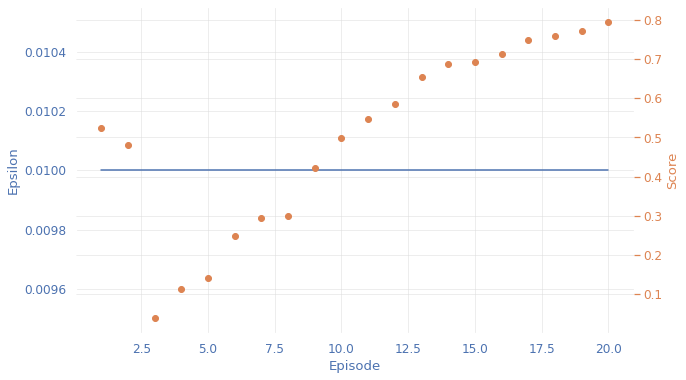

In [ ]:
trainingenv = TradingEnv(marketSymbol="JPM", period=PERIOD_DEFAULT, startingDate=START_DEFAULT,
                         endingDate=END_DEFAULT, columns=COLUMNS, money=1000000, transactionCosts=0)
lr = 0.001
agent = Agent(gamma=1, epsilon=1, alpha=lr, input_dims=117,
              n_actions=2, mem_size=1000000, batch_size=32, epsilon_end=0.01)
agent.train_model(trainingenv)

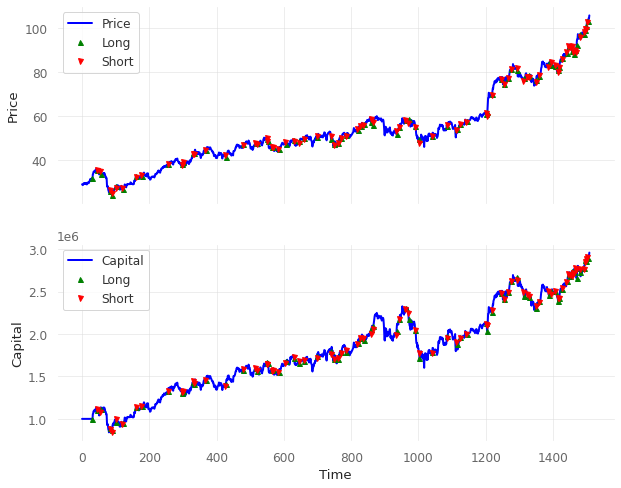

In [ ]:
trainingenv.render()

=====================Performance Metrics=====================
Sharpe Ratio    0.14      
Sortino Ratio   0.2       
Annualized Volatility 0.2       
Profit Ratio    0.55      
Max Drawdown    -0.16     
Annualized Retruns 0.03      


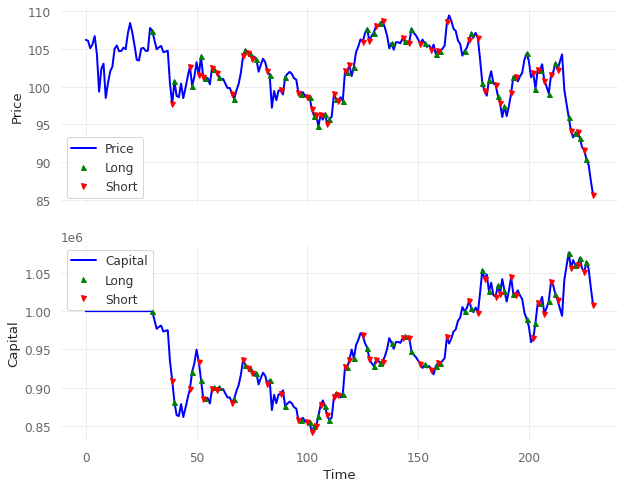

In [ ]:
agent = Agent(gamma=1, epsilon=1, alpha=lr, input_dims=117,
              n_actions=2, mem_size=1000000, batch_size=32, epsilon_end=0.01)
testingenv = TradingEnv(marketSymbol="JPM", period=PERIOD_DEFAULT, startingDate=BACKTEST_START_DEFAULT,
                        endingDate=BACKTEST_END_DEFAULT, columns=COLUMNS, money=1000000, transactionCosts=0)
agent.backtest(testingenv)

episode:  0 score: -0.11  average score -0.11
episode:  1 score: 0.41  average score 0.15
episode:  2 score: 0.55  average score 0.28
episode:  3 score: 0.72  average score 0.39
episode:  4 score: -0.57  average score 0.20
episode:  5 score: 0.92  average score 0.32
episode:  6 score: 0.19  average score 0.30
episode:  7 score: 0.48  average score 0.32
episode:  8 score: 0.23  average score 0.31
episode:  9 score: 0.06  average score 0.29
episode:  10 score: 0.97  average score 0.35
episode:  11 score: 0.63  average score 0.37
episode:  12 score: 0.72  average score 0.40
episode:  13 score: 0.61  average score 0.41
episode:  14 score: 0.51  average score 0.42
episode:  15 score: 0.08  average score 0.40
episode:  16 score: 1.08  average score 0.44
episode:  17 score: 1.22  average score 0.48
episode:  18 score: 1.45  average score 0.53
episode:  19 score: 1.28  average score 0.57
=====================Performance Metrics=====================
Sharpe Ratio    0.98      
Sortino Ratio   1.

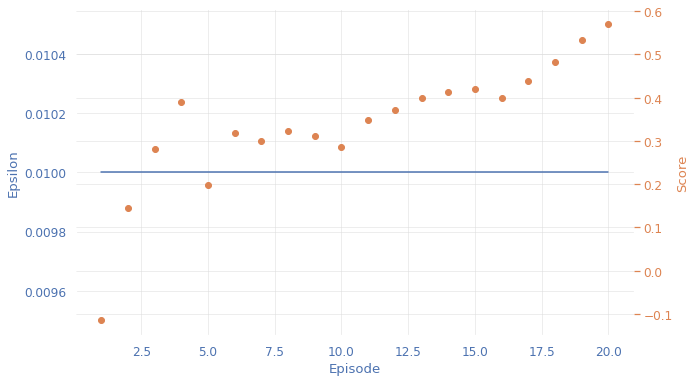

In [ ]:
trainingenv = TradingEnv(marketSymbol="MSFT", period=PERIOD_DEFAULT, startingDate=START_DEFAULT,
                         endingDate=END_DEFAULT, columns=COLUMNS, money=1000000, transactionCosts=0)
lr = 0.005
agent = Agent(gamma=1, epsilon=1, alpha=lr, input_dims=117,
              n_actions=2, mem_size=1000000, batch_size=32, epsilon_end=0.01)
agent.train_model(trainingenv, n_episodes=20)

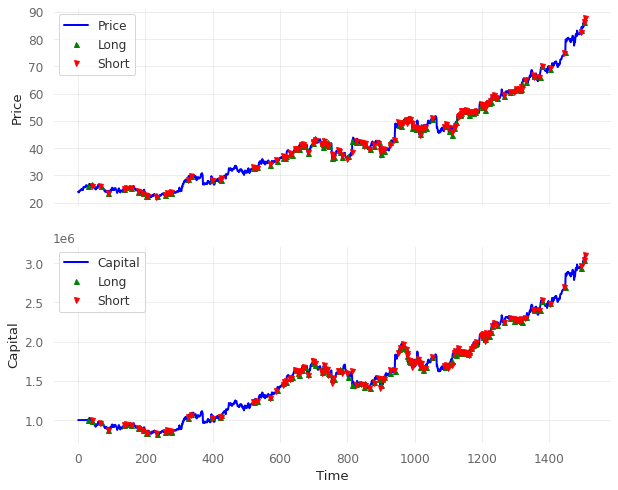

In [ ]:
trainingenv.render()

=====================Performance Metrics=====================
Sharpe Ratio    0.79      
Sortino Ratio   1.2       
Annualized Volatility 0.26      
Profit Ratio    0.57      
Max Drawdown    -0.15     
Annualized Retruns 0.2       


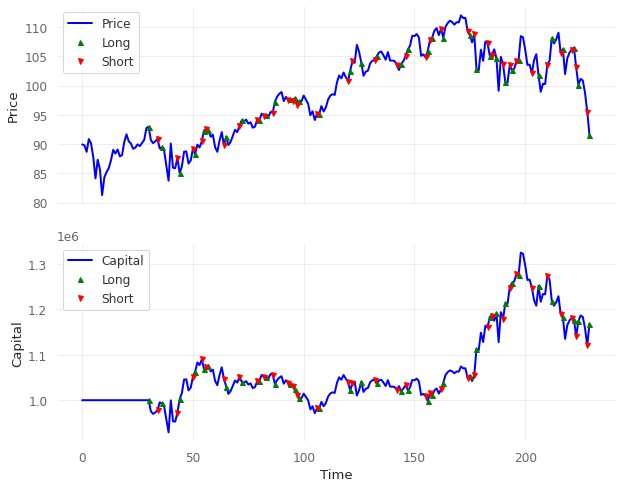

In [ ]:
testingenv = TradingEnv(marketSymbol="MSFT", period=PERIOD_DEFAULT, startingDate=BACKTEST_START_DEFAULT,
                        endingDate=BACKTEST_END_DEFAULT, columns=COLUMNS, money=1000000, transactionCosts=0)
agent.backtest(testingenv)

episode:  0 score: -0.96  average score -0.96
episode:  1 score: -1.19  average score -1.07
episode:  2 score: -1.55  average score -1.23
episode:  3 score: -1.55  average score -1.31
episode:  4 score: -1.44  average score -1.34
episode:  5 score: -1.26  average score -1.32
episode:  6 score: -1.46  average score -1.34
episode:  7 score: 0.48  average score -1.12
episode:  8 score: 1.42  average score -0.83
episode:  9 score: 1.06  average score -0.64
episode:  10 score: 1.38  average score -0.46
episode:  11 score: 1.32  average score -0.31
episode:  12 score: 1.29  average score -0.19
episode:  13 score: 1.36  average score -0.08
episode:  14 score: 1.17  average score 0.01
episode:  15 score: 1.13  average score 0.08
episode:  16 score: 1.11  average score 0.14
episode:  17 score: 1.19  average score 0.20
episode:  18 score: 1.39  average score 0.26
episode:  19 score: 1.12  average score 0.30
=====================Performance Metrics=====================
Sharpe Ratio    0.85      


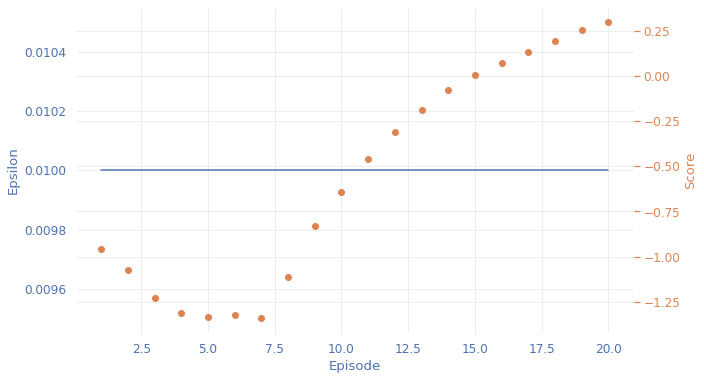

In [ ]:
trainingenv = TradingEnv(marketSymbol="MSFT", period=PERIOD_DEFAULT, startingDate=START_DEFAULT,
                         endingDate=END_DEFAULT, columns=COLUMNS, money=1000000, transactionCosts=0.1/100)
lr = 0.005
agent = Agent(gamma=1, epsilon=1, alpha=lr, input_dims=117,
              n_actions=2, mem_size=1000000, batch_size=32, epsilon_end=0.01)
agent.train_model(trainingenv, n_episodes=20)

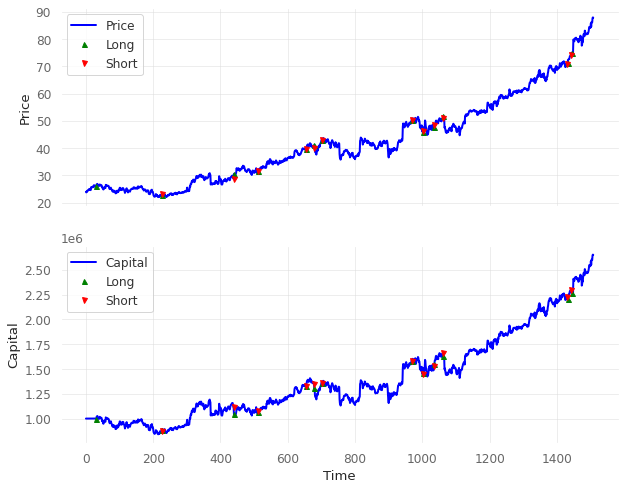

In [ ]:
trainingenv.render()

=====================Performance Metrics=====================
Sharpe Ratio    -0.12     
Sortino Ratio   -0.16     
Annualized Volatility 0.26      
Profit Ratio    0.45      
Max Drawdown    -0.18     
Annualized Retruns -0.03     


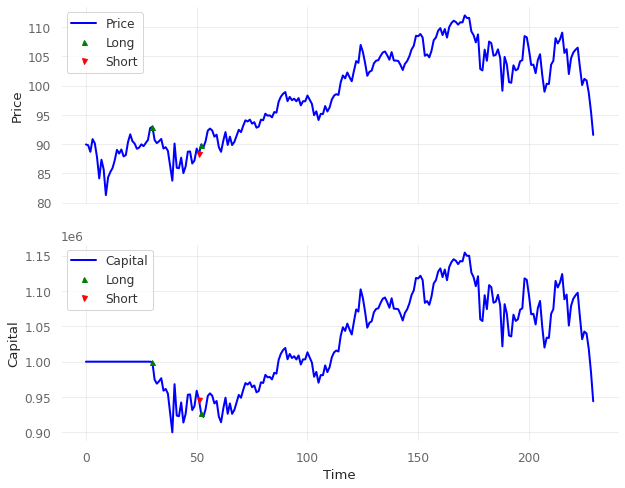

In [ ]:
testingenv = TradingEnv(marketSymbol="MSFT", period=PERIOD_DEFAULT, startingDate=BACKTEST_START_DEFAULT,
                        endingDate=BACKTEST_END_DEFAULT, columns=COLUMNS, money=1000000, transactionCosts=0.1/100)
agent.backtest(testingenv)

=====================Performance Metrics=====================
Sharpe Ratio    0.21      
Sortino Ratio   0.29      
Annualized Volatility 0.28      
Profit Ratio    0.71      
Max Drawdown    -0.18     
Annualized Retruns 0.06      


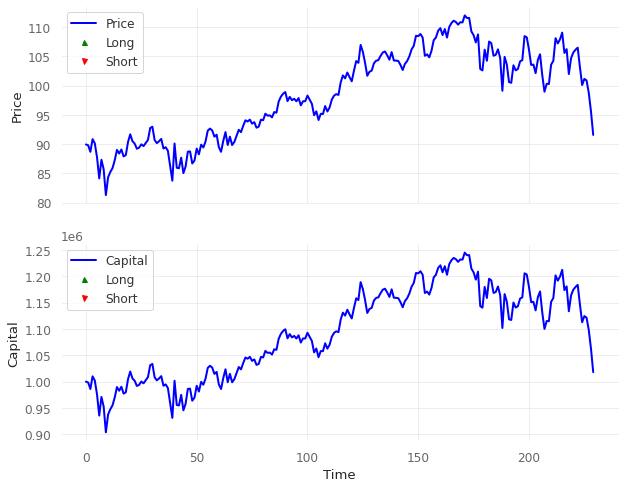

In [37]:
test_portfolio = Vanilla_Trading_Strategy(marketSymbol="MSFT", period=PERIOD_DEFAULT, startingDate=BACKTEST_START_DEFAULT,
                                          endingDate=BACKTEST_END_DEFAULT, indicator='B&H', initial_money=1000000, t_costs=0)
test_portfolio.execute_trading_strategy()
test_portfolio.trading_report()

=====================Performance Metrics=====================
Sharpe Ratio    0.07      
Sortino Ratio   0.11      
Annualized Volatility 0.28      
Profit Ratio    1.39      
Max Drawdown    -0.27     
Annualized Retruns 0.02      


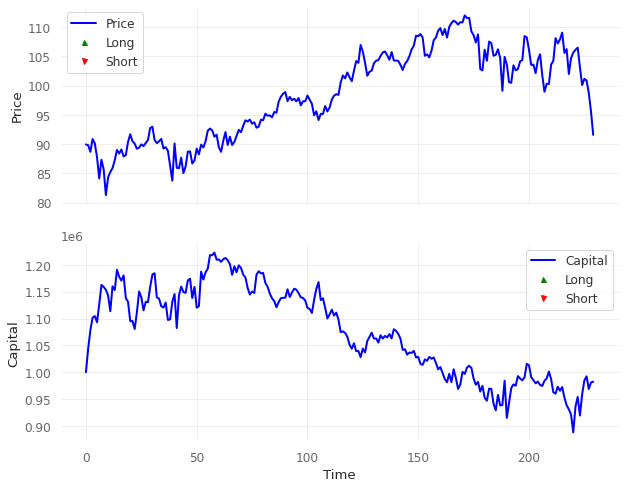

In [38]:
test_portfolio = Vanilla_Trading_Strategy(marketSymbol="MSFT", period=PERIOD_DEFAULT, startingDate=BACKTEST_START_DEFAULT,
                                          endingDate=BACKTEST_END_DEFAULT, indicator='S&H', initial_money=1000000, t_costs=0)
test_portfolio.execute_trading_strategy()
test_portfolio.trading_report()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:176: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



=====================Performance Metrics=====================
Sharpe Ratio    1.07      
Sortino Ratio   1.61      
Annualized Volatility 0.22      
Profit Ratio    0.03      
Max Drawdown    -0.09     
Annualized Retruns 0.24      


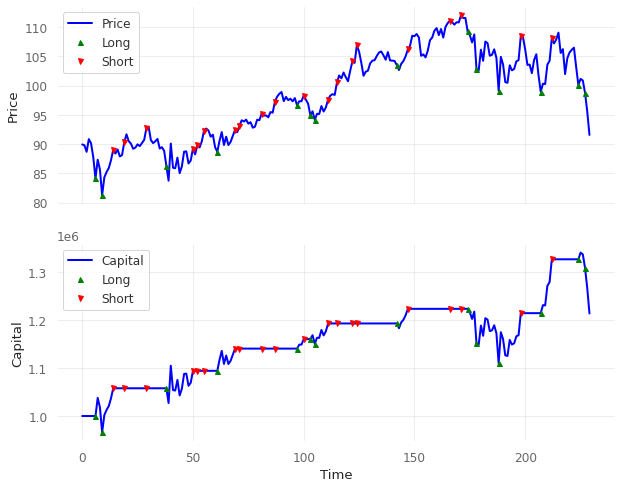

In [39]:
test_portfolio = Vanilla_Trading_Strategy(marketSymbol="MSFT", period=PERIOD_DEFAULT, startingDate=BACKTEST_START_DEFAULT,
                                          endingDate=BACKTEST_END_DEFAULT, indicator='BBANDS', initial_money=1000000, t_costs=0)
test_portfolio.execute_trading_strategy()
test_portfolio.trading_report()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:176: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



=====================Performance Metrics=====================
Sharpe Ratio    -0.29     
Sortino Ratio   -0.39     
Annualized Volatility 0.17      
Profit Ratio    0.1       
Max Drawdown    -0.12     
Annualized Retruns -0.05     


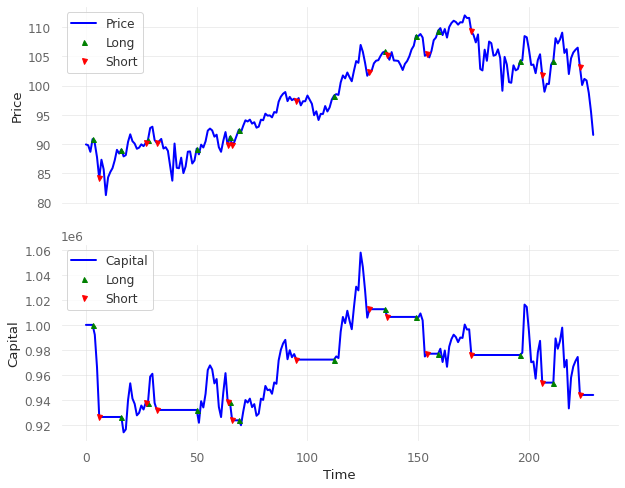

In [40]:
test_portfolio = Vanilla_Trading_Strategy(marketSymbol="MSFT", period=PERIOD_DEFAULT, startingDate=BACKTEST_START_DEFAULT,
                                          endingDate=BACKTEST_END_DEFAULT, indicator='MACD', initial_money=1000000, t_costs=0)
test_portfolio.execute_trading_strategy()
test_portfolio.trading_report()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:176: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



=====================Performance Metrics=====================
Sharpe Ratio    0         
Max Drawdown    0.0       
Annualized Retruns 0.0       
Sortino Ratio   0         
Annualized Volatility 0         
Profit Ratio    0         


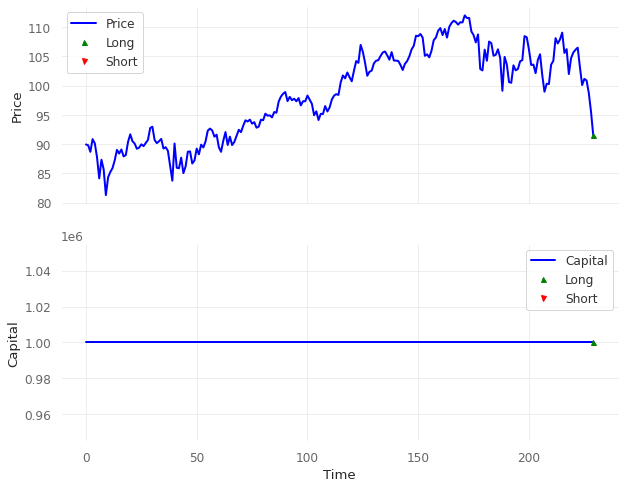

In [41]:
test_portfolio = Vanilla_Trading_Strategy(marketSymbol="MSFT", period=PERIOD_DEFAULT, startingDate=BACKTEST_START_DEFAULT,
                                          endingDate=BACKTEST_END_DEFAULT, indicator='RSI', initial_money=1000000, t_costs=0)
test_portfolio.execute_trading_strategy()
test_portfolio.trading_report()